# Assignment 5: Gradient Descent - Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection
import seaborn as sns

In [2]:
# Set up data 
diabetes_X, diabetes_y = sklearn.datasets.load_diabetes(return_X_y = True)
# Split into train and test sets
split = sklearn.model_selection.train_test_split(diabetes_X, diabetes_y)
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = split

## 1. Loss Functions

In this exercise we'll be considering a simple linear model:

$$y \approx \theta x$$

The hypothesis for the model is written as

$$h(\theta) = \theta x$$

### a. Fill in the following methods for the loss functions and their derivatives.


In [3]:
def squared_loss(X, theta, y):
    """
    Returns the squared loss
    
    Input:
    X: n length vector - n datapoints
    theta: scalar
    y: n length vector
    
    Output:
    loss: scalar
    """
    return np.linalg.norm(theta*X - y)**2

In [4]:
def squared_deriv(X, theta, y):
    """
    Returns the gradient wrt theta of the squared loss
    
    Input:
    X: n length vector - n datapoints
    theta: scalar
    y: n length vector
    
    Output:
    grad: scalar
    """
    return 2*theta*np.linalg.norm(X)**2 - 2*X.dot(y)

In [5]:
def abs_loss(X, theta, y):
    """
    Returns the absolute value loss
    
    Input:
    X: n length vector - n datapoints
    theta: scalar
    y: n length vector
    
    Output:
    loss: scalar
    """
    return np.linalg.norm(theta*X - y, ord=1)

In [6]:
def abs_deriv(X, theta, y):
    """
    Returns the gradient wrt theta of the absolute loss
    
    Input:
    X: n length vector - n datapoints
    theta: scalar
    y: n length vector
    
    Output:
    grad: scalar
    """
    return np.sum(np.sign(theta*X - y)*X)

### b. Plot the loss and the gradient for the provided data, simple_x and simple_y

In other words, compute an array of losses + gradients with pos_theta (find  loss and gradient for each possible theta).

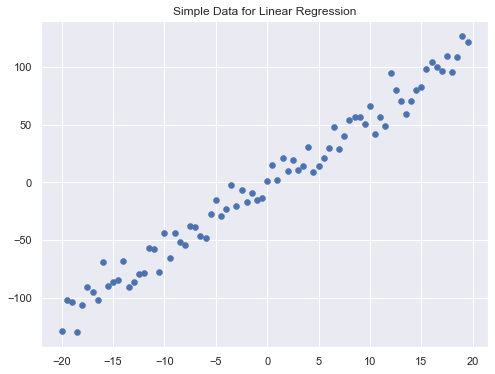

In [7]:
sns.set_theme()
# Data you'll use with the above methods
simple_x = np.arange(-20,20,0.5)

# Yields a float between 3 and 7
true_theta = 4*np.random.random_sample()+3
# Add noise and scale y
simple_y = true_theta*simple_x + np.random.normal(scale = 10, size=simple_x.shape)

plt.figure(figsize = (8,6))
plt.title("Simple Data for Linear Regression")
plt.scatter(simple_x, simple_y, linewidths=0.5)
plt.show()

In [8]:
# Possible theta values (to iterate through)
pos_theta = np.arange(0, 10, 0.01)

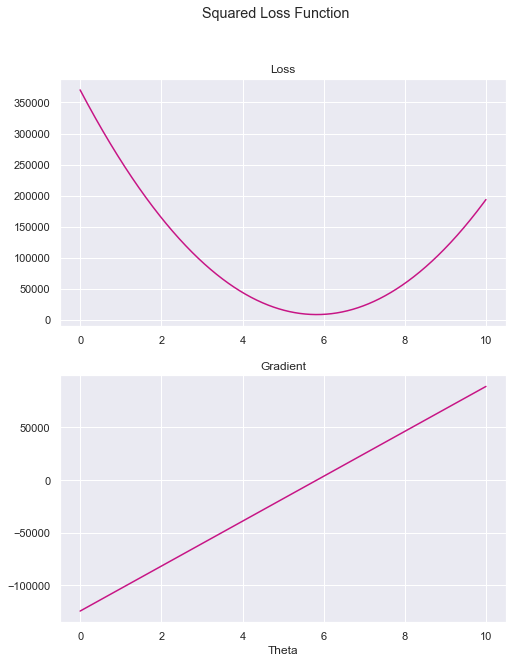

In [9]:
# Plot squared loss and gradient
plt.figure(figsize=(8,10))
plt.suptitle("Squared Loss Function")
plt.subplots_adjust(hspace=0.2)
plt.subplot(2,1,1)

# TODO: Find and plot loss
losses = [squared_loss(simple_x, theta, simple_y) for theta in pos_theta]
plt.plot(pos_theta, losses, c='mediumvioletred')
plt.title("Loss")

plt.subplot(2,1,2)

# TODO: Find and plot gradient
grad = [squared_deriv(simple_x, theta, simple_y) for theta in pos_theta]
plt.plot(pos_theta, grad, c='mediumvioletred')
plt.title("Gradient")
plt.xlabel("Theta")

plt.show()

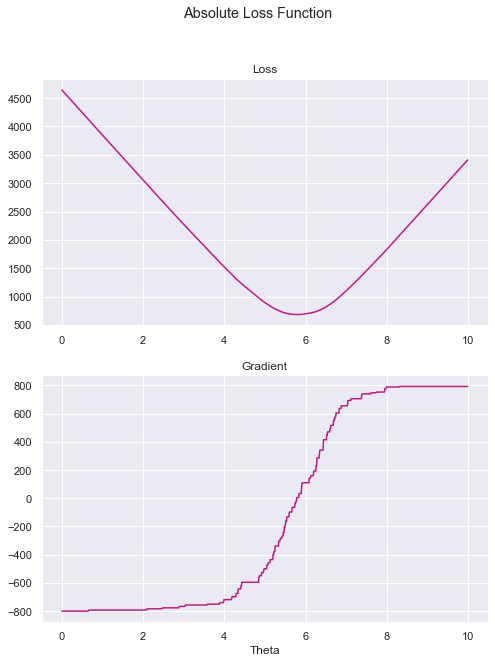

In [10]:
# Plot absolute loss and gradient
plt.figure(figsize=(8,10))
plt.suptitle("Absolute Loss Function")
plt.subplots_adjust(hspace=0.2)
plt.subplot(2,1,1)

# TODO: Find and plot loss
losses = [abs_loss(simple_x, theta, simple_y) for theta in pos_theta]
plt.plot(pos_theta, losses, c='mediumvioletred')
plt.title("Loss")

plt.subplot(2,1,2)

# TODO: Find and plot gradient
grad = [abs_deriv(simple_x, theta, simple_y) for theta in pos_theta]
plt.plot(pos_theta, grad, c='mediumvioletred')
plt.title("Gradient")
plt.xlabel("Theta")

plt.show()

### c. Given that the gradient descent algorithm uses the first derivative to  find a local minimum, which of the above loss functions is preferable for linear regression using gradient descent? Briefly explain using the above plots.

#### Answer:
<font color=blue> 
The squared loss is preferable since the gradient is smooth and differentiable everywhere. It is also computationally easier since it is just a linear function on $\theta$. Additionally, the magnitude of the gradient for the absolute error is large around the optimum, so if the step size for gradient descent is too large, then the algorithm can oscillate around the optimum without converging.
</font>


## 2. Gradient Descent Linear Regression

Here you'll implement a linear regressor using gradient descent and the diabetes dataset initialized at the top of this assignment. Using the L2-norm squared loss function, the gradient descent algorithm will follow the below given formula to update the parameters and find the optimal solution.
______
The model:

$$ y \approx X w $$

Hypothesis:

$$ h(w) = Xw $$
______
**Gradient Descent Update Function:**

$$ w_{n+1} = w_n - \alpha \nabla L(w_n) $$

Due to the relatively small size of the dataset, use all datapoints for computing the gradient (also known as batch gradient descent - compare to stochastic gradient descent, an optimization over batch).

_____

The L2-norm squared loss for this model is written as

$$ L(w) = ||X w - y ||^2_2 $$

_____

### a. Find the gradient of the loss function with respect to w.

#### Answer:

<font color=blue> 
    
$\begin{equation*} \begin{split} L(w) & = \|Xw - y\|_2^2 = \langle Xw - y, Xw - y \rangle \\ & = (w^TX^T - y^T)(Xw - y) \\ & = w^TX^TXw - w^TX^Ty - y^TXw + y^Ty \\ & = w^TX^TXw - 2y^TXw + y^Ty \end{split} \end{equation*}$
    
$\Rightarrow \nabla_w L(w) = (X^TX + X^TX)w - 2(y^TX)^T = 2X^TXw - 2X^Ty$
</font>

### b. Implement the following methods to perform linear regression using gradient descent.

In [11]:
def gd_linreg(X, y, alpha, loss_func, derivative_func, epsilon=0.001, max_iters=10000):
    """
    Performs linear regression on X and y using gradient descent

    Input:
    X: n x m matrix - n datapoints, m features
    y: n length vector
    alpha: step size for gradient descent update
    loss_func: method to compute loss between two quantities
    derivative_func: method to compute gradient wrt w
    epsilon: maximum difference between the w_n+1 and w_n for convergence 

    Output:
    w: m length vector - weights for each feature of a data point
    losses: array of losses at each step/iteration
    """
    w = np.random.uniform(size=X.shape[1])
    losses = []
    
    for _ in range(max_iters):
        losses.append(loss_func(X, w, y))
        step_value = alpha*derivative_func(X, w, y)
        
        if np.linalg.norm(step_value) < epsilon:
            break
            
        w = w - step_value
    
    return w, losses

In [12]:
def loss_linreg(X, w, y):
    """
    Evaluates the loss function
    
    Input:
    X: n x m - n datapoints, m features
    w: m length vector - weights for features in X
    y: n length vector
    
    Output:
    loss: scalar
    """
    return np.linalg.norm(X.dot(w) - y)**2

In [13]:
def derivative_loss_linreg(X, w, y):
    """
    Finds the derivative of the loss function wrt w
    
    Input:
    X: n x m - n datapoints, m features
    w: m length vector - weights for features in X
    y: n length vector

    Output:
    gradient: length m array - gradient wrt w
    """
    return 2*(X.T.dot(X)).dot(w) - 2*X.T.dot(y)

### c. Run gradient descent with an appropriate step size.

In [14]:
# TODO: set an appropriate alpha
alpha = 0.3

diabetes_w, losses = gd_linreg(diabetes_X_train, diabetes_y_train, alpha, loss_linreg, derivative_loss_linreg)

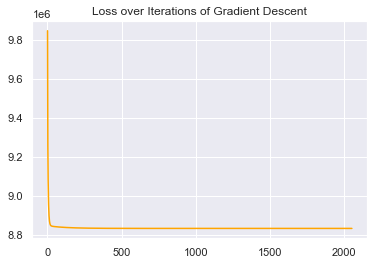

In [15]:
# Plot losses (may help find a good value for alpha)
num_iter = len(losses)

plt.title("Loss over Iterations of Gradient Descent")
plt.plot(range(1, num_iter+1), losses, c = 'orange');

## 3. Evaluate your Implementation

### a. Find the loss for the training set and the test set using the weights found with gradient descent.

In [16]:
# TODO:
gd_train_loss = loss_linreg(diabetes_X_train, diabetes_w, diabetes_y_train)
gd_test_loss = loss_linreg(diabetes_X_test, diabetes_w, diabetes_y_test)

print("Method: Gradient Descent")
print("Training Loss: " + str(gd_train_loss))
print("Test Loss: " + str(gd_test_loss))

Method: Gradient Descent
Training Loss: 8832539.753149841
Test Loss: 2699774.371604157


### b. Write and implement the OLS solution for w.

The OLS solution sets the above found gradient of the loss wrt to w to 0 (from 2a) and solves for w.



#### Answer:
<font color=blue> 
Assuming that the matrix $X^TX$ is not singular, we have the following solution:    
    
    
$\nabla_w L(w) = 2X^TXw - 2X^Ty = 0 \; \Rightarrow \; X^TXw = X^Ty \; \Rightarrow \; w = (X^TX)^{-1}X^Ty$
</font>

In [17]:
def OLS(X, y):
    """
    Finds OLS solution to linear regression of X and y

    Input:
    X: n x m - n datapoints, m features
    y: n length vector

    Output:
    w: m length vector - weights for features in X
    """
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [18]:
ols_w = OLS(diabetes_X_train, diabetes_y_train)

### c. Find the loss for the training set and the test set using the weights found with OLS.

In [19]:
# TODO:
ols_train_loss = loss_linreg(diabetes_X_train, ols_w, diabetes_y_train)
ols_test_loss = loss_linreg(diabetes_X_test, ols_w, diabetes_y_test)

print("Method: OLS")
print("Training Loss: " + str(ols_train_loss))
print("Test Loss: " + str(ols_test_loss))

Method: OLS
Training Loss: 8832539.752755241
Test Loss: 2699775.7828190406
